In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [3]:
assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
#smoke_test = 'CI' in os.environ

In [4]:
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')

In [5]:
from torch.distributions.utils import (_sum_rightmost, broadcast_all,
                                       lazy_property, tril_matrix_to_vec,
                                       vec_to_tril_matrix)

In [280]:
import torch.nn.functional as F
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.input_dim = input_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim[0]*input_dim[1], hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        val = int((z_dim**2 + z_dim) / 2)
        self.fc22 = nn.Linear(hidden_dim, val) # z_dim**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.fc1(x.reshape(x.shape[0], self.input_dim[0] * self.input_dim[1]))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        A_vect = self.fc22(hidden)
        A = vec_to_tril_matrix(A_vect)
        z_scale = torch.bmm(A, A.transpose(1, 2))
        z_scale.add_(torch.eye(self.z_dim)*1)
        return z_loc, z_scale


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=5, hidden_dim=250, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, sigma, x):
        # register PyTorch module `decoder` with Pyro
        # pyro.module("decoder", self.decoder)
        
        # setup hyperparameters for prior p(z)
        mu_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
        mu_scale = torch.eye(x[0].shape[1]).reshape(
            (1,x[0].shape[1],x[0].shape[1])).repeat(x.shape[0], 1, 1)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # sample from prior (value will be sampled by guide when computing the ELBO
            mu = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(mu_loc[i,:], mu_scale[i,:,:]))
            scale = sigma[i,:,:]
            
            with pyro.plate("data_loop_{}".format(i), x[i].shape[0]):
                pyro.sample("obs_{}".format(i), dist.MultivariateNormal(mu, scale),
                                obs=x[i, :, :])
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, sigma, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x[i].unsqueeze(0))

            # sample the latent code z
            mu = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(z_loc, z_scale))
            
            scale = sigma[i,:,:]

In [281]:
# write a function to find this exact posterior 
def get_posterior_cov_mv_gaussian(n, sigma, sigma_0):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, 1/n * sigma)
    return(p2)

def get_posterior_mean_mv_gaussian(n, sigma, sigma_0, mu_0, data):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    
    middle_part = data.mean(axis=0)
    
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, middle_part)
    
    p3 = np.matmul(1/n * sigma, sum_part)
    p4 = np.matmul(p3, mu_0)
    return(p2 + p4)

In [282]:
def multivar_random(size, normal_params, gamma_params, cov_matrix, num_samples):   
    
    mat_0 = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat_0 = torch.tensor(np.dot(mat_0, mat_0.transpose()))
    
    # simulate some random means
    mu_vector = torch.tensor(np.random.multivariate_normal(normal_params, sigma_mat_0, size=1))[0]

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, cov_matrix, size=num_samples).astype("float32"))
    
    return (data, mu_vector, cov_matrix, sigma_mat_0)

In [299]:
X = []
means = []
sigma_mats = []
sigma_0s = []

# generate covariance
mat = np.random.gamma(1, 1, size=5**2).reshape((5, 5))
sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))
sigma_mat = torch.eye(5)
for idx in range(1000):
    random_means = np.random.sample(size=5) 
    
    data, mu_vector, sigma_mat, sigma_mat_0 = multivar_random(5, [1]*5, [5,5], sigma_mat, num_samples=500)
    X.append([data, sigma_mat])
    means.append(mu_vector)
    sigma_mats.append(sigma_mat)
    sigma_0s.append(sigma_mat_0)

In [311]:
X

[[tensor([[  4.9765,   3.6918,  -2.2205,  18.3461, -33.4327],
          [  3.1040,   2.5620,   0.1528,  16.2533, -34.2466],
          [  4.5641,   1.4375,   0.1908,  16.5121, -35.0629],
          ...,
          [  6.1816,   1.9501,   0.1511,  16.0553, -33.1900],
          [  5.1421,   1.9682,  -0.8777,  14.2143, -32.7983],
          [  3.0658,   3.0036,  -0.5980,  15.0519, -32.8435]]),
  tensor([[1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1.]])],
 [tensor([[ -1.4691, -57.9079,  32.2131, -38.9807, -19.7301],
          [ -0.8852, -57.6966,  34.1497, -42.0955, -20.4191],
          [ -0.7485, -57.7246,  34.5450, -42.3620, -19.5647],
          ...,
          [ -1.2791, -58.1432,  33.9626, -39.2971, -20.6112],
          [ -1.0200, -57.6313,  32.2270, -40.9585, -19.6741],
          [ -1.8533, -58.3037,  32.9775, -40.2178, -19.6347]]),
  tensor([[1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 

In [300]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = (500, 5)
mu = stats.norm.rvs(size=input_dim)

# setup the VAE
vae = VAE(use_cuda=False, input_dim=input_dim, z_dim=5)

adam_args = {"lr": 1e-5}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_loader = DataLoader(X, batch_size=500, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

train_elbo = []

for epoch in range(100):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    print("Epoch: ", epoch, end = "\r")
    for x, sigma in train_loader:
        # x = x.cuda()
        epoch_loss += svi.step(sigma, x)

    # report training diagnostics
    if not epoch % 2:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 7512224.6542
[epoch 002]  average training loss: 4458013.5658
[epoch 004]  average training loss: 2605928.5427
[epoch 006]  average training loss: 1526522.9292
[epoch 008]  average training loss: 975402.2069
[epoch 010]  average training loss: 815806.0374
[epoch 012]  average training loss: 811676.1050
[epoch 014]  average training loss: 793398.8585
[epoch 016]  average training loss: 763466.1420
[epoch 018]  average training loss: 677039.2999
[epoch 020]  average training loss: 619511.1501
[epoch 022]  average training loss: 558604.9452
[epoch 024]  average training loss: 488992.2406
[epoch 026]  average training loss: 444001.3194
[epoch 028]  average training loss: 416731.1710
[epoch 030]  average training loss: 367667.2357
[epoch 032]  average training loss: 328285.8187
[epoch 034]  average training loss: 307434.7656
[epoch 036]  average training loss: 299649.2902
[epoch 038]  average training loss: 258790.2722
[epoch 040]  average training loss: 

KeyboardInterrupt: 

Text(0, 0.5, 'ELBO loss')

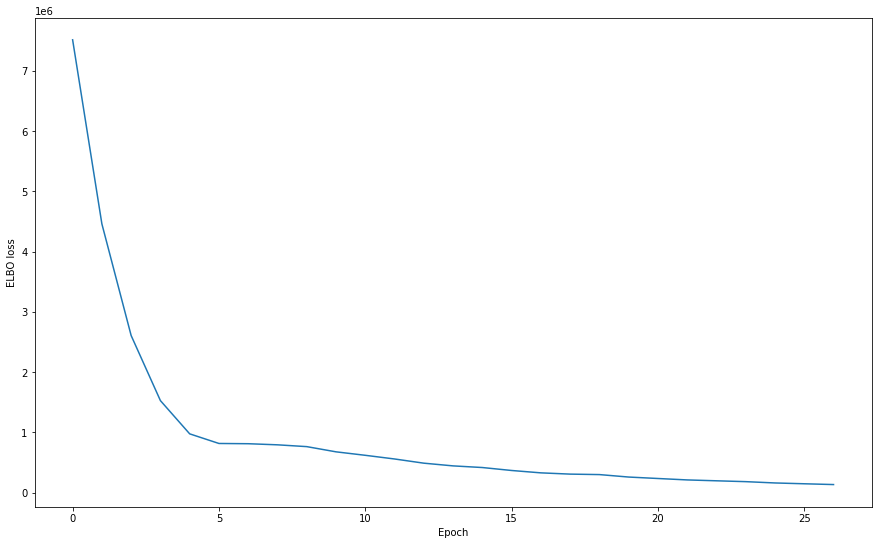

In [301]:
plt.figure(figsize=(15, 9))
plt.plot([i for i in range(len(train_elbo))], train_elbo)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")

In [302]:
count = 0
for name, value in pyro.get_param_store().items():
    print(name)

encoder$$$fc1.weight
encoder$$$fc1.bias
encoder$$$fc21.weight
encoder$$$fc21.bias
encoder$$$fc22.weight
encoder$$$fc22.bias


In [303]:
vae.encoder.eval()

Encoder(
  (fc1): Linear(in_features=2500, out_features=250, bias=True)
  (fc21): Linear(in_features=250, out_features=5, bias=True)
  (fc22): Linear(in_features=250, out_features=15, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [306]:
idx = 1
X[idx][0].shape
mean_pred = vae.encoder.forward(X[idx][0].unsqueeze(0))[0]
mean_act = means[idx]
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[  2.0081, -49.6932,  19.3843, -30.6798, -22.4106]],
       grad_fn=<AddmmBackward0>).
Actual means: tensor([ -0.2538, -57.8525,  33.4436, -40.7455, -19.7007], dtype=torch.float64).


In [308]:
x_i, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [5,5], sigma_mat, 500)
mean_pred = vae.encoder.forward(x_i.reshape(1, 500, 5))[0]
mean_act = get_posterior_mean_mv_gaussian(50, sigma, sigma_0, mu_vector, x_i)
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[85.3831, 86.4857, 79.2499, 50.2130, 64.3342]],
       grad_fn=<AddmmBackward0>).
Actual means: tensor([92.1507, 95.9442, 90.4158, 32.2143, 64.2446], dtype=torch.float64).


In [241]:
x_i, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [.5]*4, sigma_mat, 500)
cov_pred = vae.encoder.forward(x_i.reshape(1, 500, 5))[1]
cov_act = get_posterior_cov_mv_gaussian(50, sigma, sigma_0)
print("Predicted COV: {}.".format(cov_pred))
print("Actual COV: {}.".format(cov_act))

Predicted COV: tensor([[[ 0.0499,  0.0958, -0.0376, -0.0674,  0.0633],
         [ 0.0958,  0.5272,  0.0534, -0.2917,  0.6305],
         [-0.0376,  0.0534,  0.6765, -0.2101,  0.0319],
         [-0.0674, -0.2917, -0.2101,  0.2492, -0.2919],
         [ 0.0633,  0.6305,  0.0319, -0.2919,  0.9216]]],
       grad_fn=<AddBackward0>).
Actual COV: tensor([[ 0.0113, -0.0046,  0.0024,  0.0059, -0.0016],
        [-0.0046,  0.0147,  0.0027,  0.0042, -0.0015],
        [ 0.0024,  0.0027,  0.0185, -0.0020,  0.0009],
        [ 0.0059,  0.0042, -0.0020,  0.0139,  0.0015],
        [-0.0016, -0.0015,  0.0009,  0.0015,  0.0189]], dtype=torch.float64).
